# Faster Peak Reinforcement Learning Convergence and Improved Model Efficacy Using Mish Activation Function

Christian Rouhana christian.rouhana@wsu.edu

Cpt_S 434 Final Project

The goal of this project was to investigate an application of the [Mish (view paper here)](https://arxiv.org/abs/1908.08681) activation function to see if a standard Actor Critic network can achieve competitive results to traditionally faster algorithms submitted in the [OpenAI Gym leaderboard](https://github.com/openai/gym/wiki/Leaderboard). A demonstration of an Actor Critic algorithm's convergence speed using Mish, Softmax, and Alex is presented here, followed by a comparison of the same algorithm where the Mish activation function is replaced by ReLU. Interesting implications for model efficacy are presented. Standard Actor Critic algorithm is chosen due to processing limitations and time

The Mish activation function is mathematically represented as

$$ f(x) = xtanh(softplus(x)) $$

Mish github repository can be found [here](https://github.com/digantamisra98/Mish)

Mish implementation in tensorflow-addons can be found [here](https://www.tensorflow.org/addons/api_docs/python/tfa/activations/mish)

[Documentation for OpenAI Gym](https://gym.openai.com/docs/)

In [1]:
# Partially adapted from: https://keras.io/examples/rl/actor_critic_cartpole/
# & https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic
import gym
import keras
from keras import layers
import tensorflow as tf
import numpy as np
import sys
import os
from os.path import isfile
import tensorflow_addons as tfa
from IPython.display import Image
import matplotlib.pyplot as plt

# Generating Model with Mish Activation

In [2]:
seed = 42
n_actions = 2
n_inputs = 4
n_hidden = 64
lr = 0.003
gamma = 0.99
MAX_STEPS = 10000 #max steps per episode
eps = np.finfo(np.float32).eps.item()
states, action_prob_grads, rewards, action_probs = [], [], [], []
reward_sum = 0
episode_number = 0

In [16]:
#common layers
inputs = layers.Input(shape = (n_inputs, ))
l1 = layers.Dense(n_hidden)(inputs)
l2 = tfa.activations.mish(l1)
l3 = layers.BatchNormalization()(l2)
l4 = layers.Dense(n_hidden)(l3)
l5 = tfa.activations.mish(l4)
common = layers.BatchNormalization()(l5)

#create actor and critic model
action = layers.Dense(n_actions, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model = keras.Model(inputs=inputs, outputs=[action, critic])
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.MeanSquaredError()

action_probs_history = []
critic_value_history = []
rewards_history = []
episode_count = 0
running_reward = 0
reward_plot = []

# Train CartPole

`Cartpole-v0` is used to create consistent results with algorithms submitted on the OpenAI Leaderboard

The average reward update function for an actor critic model definied in this [paper](https://hal.inria.fr/hal-00840470/document) is 
$$\hat{J}_{t+1} = (1 -\xi_t)\hat{J}_t + \xi_t r_{t+1}$$
Where $\hat{J}_{t+1}$ is the running reward, $\xi_t$ is the reward step size,  $\hat{J}_{t}$ is the episode reward, and $r_{t+1}$ is the episode reward.

The training algorithm was adapted from the [keras implementation](https://keras.io/examples/rl/actor_critic_cartpole/) where this is implemented as 

`running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward`


`running_reward = 0.15 * episode_reward + (1-0.01) * running_reward`

As it resulted in better convergence speed for the CartPole problem

In [17]:
filename_cart = 'weights_cart.h5'

In [18]:
env = gym.make('CartPole-v0')
env.seed(seed)
while True:
    state = env.reset()
    episode_reward = 0

    with tf.GradientTape() as tape:
        for step in range(1, MAX_STEPS):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = np.random.choice(n_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done: break

        #modified update running reward function from keras tutorial
        running_reward = 0.175 * episode_reward + (1-0.175) * running_reward
        reward_plot.append(running_reward)
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = np.array(returns)
        returns = (returns - np.mean(returns))/(np.std(returns)+eps)
        returns = returns.tolist()

        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob * diff)
            #update critic
            critic_losses.append(
                loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

        episode_count += 1
        if episode_count % 10 == 0:
            print("reward: {} at episode {}".format(running_reward, episode_count))
        if running_reward > 195:
            print("Solved at episode {}".format(episode_count))
            model.save_weights(filename_cart)
            break
env.close()

reward: 17.085640799223153 at episode 10
reward: 33.58398052068931 at episode 20
reward: 30.283929018874815 at episode 30
reward: 71.74664188868482 at episode 40
reward: 55.97578526275012 at episode 50
reward: 30.856578141237208 at episode 60
reward: 89.81212164295374 at episode 70
reward: 95.98882362905547 at episode 80
reward: 61.501365459406145 at episode 90
reward: 56.57557361149536 at episode 100
reward: 93.34565822332043 at episode 110
reward: 56.17618367224016 at episode 120
reward: 105.10815463253093 at episode 130
reward: 135.37067404438392 at episode 140
reward: 160.81757900162853 at episode 150
reward: 109.58080026813869 at episode 160
reward: 143.73564427761576 at episode 170
reward: 109.96568672168931 at episode 180
reward: 166.6083363121331 at episode 190
reward: 190.86149135183982 at episode 200
reward: 177.21092002312628 at episode 210


KeyboardInterrupt: 

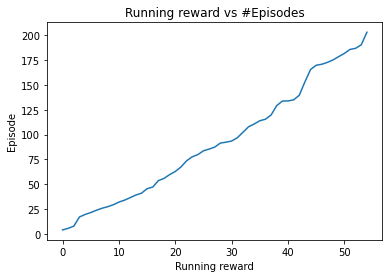

In [432]:
plt.plot(reward_plot)
plt.title('Running reward vs #Episodes')
plt.xlabel('Running reward')
plt.ylabel('Episode')
plt.show()

**Convergence consistently between 40-60 episodes on seed 42**

This performs quite well, with this individual trial coming at 22nd in the leaderboard. It is important to note most entries to the leaderboard use models that are known to perform better than a basic actor critic model. Examples include Deep Q Learning networks, A2C, A3C, and PPO networks.

# Test If Trained Model 'Solves' CartPole 

According to the OpenAI wiki, CartPole-v0 is solved if average score across 100 consecutive trials is equal to 195.0

In [33]:
seed = 42
n_actions = 2
n_inputs = 4
n_hidden = 64
lr = 0.003

env = gym.make('CartPole-v0')
env.seed(seed)

#reinitialize model
inputs = layers.Input(shape = (n_inputs, ))
l1 = layers.Dense(n_hidden)(inputs)
l2 = tfa.activations.mish(l1)
l3 = layers.BatchNormalization()(l2)
l4 = layers.Dense(n_hidden)(l3)
l5 = tfa.activations.mish(l4)
common = layers.BatchNormalization()(l5)

action = layers.Dense(n_actions, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model = keras.Model(inputs=inputs, outputs=[action, critic])
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.MeanSquaredError()


if os.path.isfile(filename_cart):
    model.load_weights(filename_cart)

score = []
trials = []
for _ in range(100):
    trial_reward = 0
    state = env.reset()

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_prob, _ = model(state)
    action = np.random.choice(n_actions, p = np.squeeze(action_prob))

    state, reward, done, info = env.step(action)
    trial_reward += reward
    # a solved Cart problem is avg score > 195 over 100 trials
    while trial_reward<=195.0: #setting cap on reward for run time
        state = env.reset()

        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)

        action_prob, _ = model(state)
        action = np.random.choice(n_actions, p = np.squeeze(action_prob))

        state, reward, done, info = env.step(action)
        trial_reward += reward
    trials.append(trial_reward)

print('Average reward over 100 trials: {}'.format(sum(trials)/100))
if sum(trials)/100:
    print('Average trial score is over 195, problem is solved.')

Average reward over 100 trials: 196.0
Average trial score is over 195, problem is solved.


**(Screenshot) Trained weights successfully balancing pole**:

Trained weights run in different file with `env.render()` set to true and `time.sleep(1/60)` to be easily watched
![res.png](res.png)

# Make sure equivalet ReLU algorithm can solve CartPole

Before we compare the algorithms, we must make sure the same function's trained model can solve the problem

In [20]:
#initialize model
inputs = layers.Input(shape = (n_inputs, ))
l1 = layers.Dense(n_hidden)(inputs)
l2 = tfa.activations.mish(l1)
l3 = layers.BatchNormalization()(l2)
l4 = layers.Dense(n_hidden)(l3)
l5 = tfa.activations.mish(l4)
common = layers.BatchNormalization()(l5)
action = layers.Dense(n_actions, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model = keras.Model(inputs=inputs, outputs=[action, critic])
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.MeanSquaredError()

action_probs_history = []
critic_value_history = []
rewards_history = []
episode_count = 0
running_reward = 0
reward_plot = []

env = gym.make('CartPole-v0')
env.seed(seed)

filename = 'weights_relu.h5'
while True:
    state = env.reset()
    episode_reward = 0

    with tf.GradientTape() as tape:
        for step in range(1, MAX_STEPS):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = np.random.choice(n_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done: break

        #modified update running reward function from keras tutorial
        running_reward = 0.15 * episode_reward + (1-0.01) * running_reward
        reward_plot.append(running_reward)
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = np.array(returns)
        returns = (returns - np.mean(returns))/(np.std(returns)+eps)
        returns = returns.tolist()

        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob * diff)
            #update critic
            critic_losses.append(
                loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

        episode_count += 1
        if running_reward > 195:
            print("Solved at episode {}".format(episode_count))
            model.save_weights(filename)
            break
env.close()

env = gym.make('CartPole-v0')
env.seed(seed)

trials = []
for _ in range(100):
    trial_reward = 0
    state = env.reset()

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_prob, _ = model(state)
    action = np.random.choice(n_actions, p = np.squeeze(action_prob))

    state, reward, done, info = env.step(action)
    trial_reward += reward
    # a solved Cart problem is avg score > 195 over 100 trials
    while trial_reward<=195.0: #setting cap on reward for run time
        state = env.reset()

        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)

        action_prob, _ = model(state)
        action = np.random.choice(n_actions, p = np.squeeze(action_prob))

        state, reward, done, info = env.step(action)
        trial_reward += reward
    trials.append(trial_reward)

print('Average reward over 100 trials: {}'.format(sum(trials)/100))
if sum(trials)/100:
    print('Average trial score is over 195, problem is solved.')

Solved at episode 59
Average reward over 100 trials: 196.0
Average trial score is over 195, problem is solved.


# Comparison of convergence between useage of ReLU and Mish

First, we will collect data from training the model above $200 [0 <= i <= 199]$ times from scratch. Both models will reinitialize the model and environment with `seed = 42` every trial

In [6]:
mish_convergence = []
# for loop of above training code
for i in range(200):
    #initialize model
    inputs = layers.Input(shape = (n_inputs, ))
    l1 = layers.Dense(n_hidden)(inputs)
    l2 = tfa.activations.mish(l1)
    l3 = layers.BatchNormalization()(l2)
    l4 = layers.Dense(n_hidden)(l3)
    l5 = tfa.activations.mish(l4)
    common = layers.BatchNormalization()(l5)
    action = layers.Dense(n_actions, activation = 'softmax')(common)
    critic = layers.Dense(1)(common)
    model = keras.Model(inputs=inputs, outputs=[action, critic])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.MeanSquaredError()

    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    episode_count = 0
    running_reward = 0
    reward_plot = []
    
    env = gym.make('CartPole-v0')
    env.seed(seed)
    while True:
        state = env.reset()
        episode_reward = 0

        with tf.GradientTape() as tape:
            for step in range(1, MAX_STEPS):
                state = tf.convert_to_tensor(state)
                state = tf.expand_dims(state, 0)

                action_probs, critic_value = model(state)
                critic_value_history.append(critic_value[0,0])

                action = np.random.choice(n_actions, p = np.squeeze(action_probs))
                action_probs_history.append(tf.math.log(action_probs[0, action]))

                state, reward, done, _ = env.step(action)
                rewards_history.append(reward)
                episode_reward += reward

                if done: break

            #modified update running reward function from keras tutorial
            running_reward = 0.15 * episode_reward + (1-0.01) * running_reward
            reward_plot.append(running_reward)
            returns = []
            discounted_sum = 0
            for r in rewards_history[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns.insert(0, discounted_sum)

            returns = np.array(returns)
            returns = (returns - np.mean(returns))/(np.std(returns)+eps)
            returns = returns.tolist()

            history = zip(action_probs_history, critic_value_history, returns)
            actor_losses = []
            critic_losses = []
            for log_prob, value, ret in history:
                diff = ret - value
                actor_losses.append(-log_prob * diff)
                #update critic
                critic_losses.append(
                    loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                )

            loss_value = sum(actor_losses) + sum(critic_losses)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            action_probs_history.clear()
            critic_value_history.clear()
            rewards_history.clear()

            episode_count += 1
            if running_reward > 195:
                #print("Trial {} Solved at episode {}".format(i, episode_count))
                mish_convergence.append(episode_count)
                break
    env.close()
    if (i+1) % 25 == 0:
        print('Progress update, trial no. {}'.format(i + 1))

Progress update, trial no. 25
Progress update, trial no. 50
Progress update, trial no. 75
Progress update, trial no. 100
Progress update, trial no. 125
Progress update, trial no. 150
Progress update, trial no. 175
Progress update, trial no. 200


The same algorithm is trained 200 times from scratch, but the Mish activation function is replaced by ReLU. While the paper for Mish reccomends a lower learning rate in comparison to relu, in this model it was found that the equivalent learning rate of `3e-3` was acceptable with ReLU.

In [10]:
relu_convergence = []
# for loop of above training code
for i in range(200):
    #initialize model
    inputs = layers.Input(shape = (n_inputs, ))
    l1 = layers.Dense(n_hidden, activation = 'relu')(inputs)
    l2 = layers.BatchNormalization()(l1)
    l3 = layers.Dense(n_hidden, activation = 'relu')(l2)
    common = layers.BatchNormalization()(l3)
    action = layers.Dense(n_actions, activation = 'softmax')(common)
    critic = layers.Dense(1)(common)
    model = keras.Model(inputs=inputs, outputs=[action, critic])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.MeanSquaredError()

    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    episode_count = 0
    running_reward = 0
    reward_plot = []
    
    env = gym.make('CartPole-v0')
    env.seed(seed)
    while True:
        state = env.reset()
        episode_reward = 0

        with tf.GradientTape() as tape:
            for step in range(1, MAX_STEPS):
                state = tf.convert_to_tensor(state)
                state = tf.expand_dims(state, 0)

                action_probs, critic_value = model(state)
                critic_value_history.append(critic_value[0,0])

                action = np.random.choice(n_actions, p = np.squeeze(action_probs))
                action_probs_history.append(tf.math.log(action_probs[0, action]))

                state, reward, done, _ = env.step(action)
                rewards_history.append(reward)
                episode_reward += reward

                if done: break

            #modified update running reward function from keras tutorial
            running_reward = 0.15 * episode_reward + (1-0.01) * running_reward
            reward_plot.append(running_reward)
            returns = []
            discounted_sum = 0
            for r in rewards_history[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns.insert(0, discounted_sum)

            returns = np.array(returns)
            returns = (returns - np.mean(returns))/(np.std(returns)+eps)
            returns = returns.tolist()

            history = zip(action_probs_history, critic_value_history, returns)
            actor_losses = []
            critic_losses = []
            for log_prob, value, ret in history:
                diff = ret - value
                actor_losses.append(-log_prob * diff)
                #update critic
                critic_losses.append(
                    loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                )

            loss_value = sum(actor_losses) + sum(critic_losses)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            action_probs_history.clear()
            critic_value_history.clear()
            rewards_history.clear()

            episode_count += 1
            if running_reward > 195:
                #print("Trial {} Solved at episode {}".format(i, episode_count))
                relu_convergence.append(episode_count)
                break
    env.close()
    if (i+1) % 25 == 0:
        print('Progress update, trial no. {}'.format(i+1))

Progress update, trial no. 25
Progress update, trial no. 50
Progress update, trial no. 75
Progress update, trial no. 100
Progress update, trial no. 125
Progress update, trial no. 150
Progress update, trial no. 175
Progress update, trial no. 200


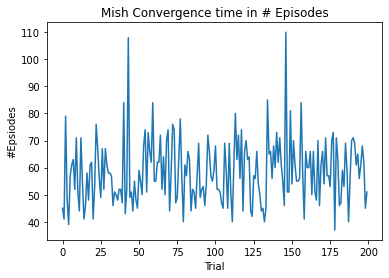

In [11]:
plt.plot(mish_convergence)
plt.title('Mish Convergence time in # Episodes')
plt.xlabel('Trial')
plt.ylabel('#Epsiodes')
plt.show()

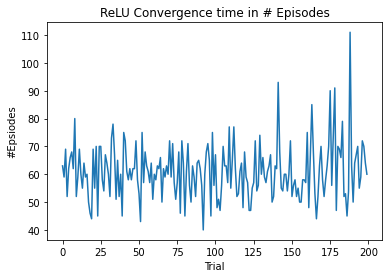

In [12]:
plt.plot(relu_convergence)
plt.title('ReLU Convergence time in # Episodes')
plt.xlabel('Trial')
plt.ylabel('#Epsiodes')
plt.show()

In [14]:
avg_mish = sum(mish_convergence)/len(mish_convergence)
peak_mish = max(mish_convergence)
min_mish = min(mish_convergence)
avg_relu = sum(relu_convergence)/len(relu_convergence)
peak_relu = max(relu_convergence)
min_relu = min(relu_convergence)
# see table in next cell
print('Mish results:')
print('Avg Convergence = {} episodes '.format(avg_mish))
print('Peak Convergence = {} episodes '.format(peak_mish))
print('Min Convergence = {} episodes '.format(min_mish))
print('ReLU results:')
print('Avg Convergence = {} episodes '.format(avg_relu))
print('Peak Convergence = {} episodes '.format(peak_relu))
print('Min Convergence = {} episodes '.format(min_relu))

Mish results:
Avg Convergence = 58.37 episodes 
Peak Convergence = 110 episodes 
Min Convergence = 37 episodes 
ReLU results:
Avg Convergence = 61.0 episodes 
Peak Convergence = 111 episodes 
Min Convergence = 40 episodes 


| Function | Avg Convergence | Fastest Convergence | Slowest Convergence | Standard Deviation |
| :---- | :---- | :---- | :---- | :---- | 
| Mish | 58.4 Eps | 37 Eps | 110 Eps | 11.65 Episodes |
| ReLU | 61.0 Eps | 40 Eps | 111 Eps | 9.84 Episodes |

In [17]:
print((avg_relu - avg_mish)/(avg_relu + avg_mish)*100) # percent difference in avg convergence
print((min_relu - min_mish)/(min_relu + min_mish)*100) # percent difference in min convergence
print((peak_relu - peak_mish)/(peak_relu + peak_mish)*100) # percent difference in peak convergence
print(np.std(mish_convergence))
print(np.std(relu_convergence))

2.203233643293962
3.896103896103896
0.4524886877828055
11.650454926739986
9.835141076771599


In our experiment of 200 trials, Mish performs ~2.2% better than ReLU in average convergence episode. Mish has a ~3.9% lower fastest individual convergence trial than ReLU. However, ReLU has a only 0.45% slower worst convergence trial at 111 episodes, with the slowest Mish trial at 110. We can draw various conclusions from this.

First, it can be observed that Mish clearly has a faster peak convergence and average convergence, but their worst convergence is fairly similar. Something of note is in informal runs with a smaller n number of trials $[n=20,50,100]$, the difference between the two less discernable. This could point to Mish showing less stability than ReLU as a whole. This can also be examined in the graphs and standard deviation for each model. The model utilizing Mish shows large peaks and valleys in the data, while ReLU shows a less erratic pattern in its data. Mish also has a greater standard deviation than ReLU at 11.65 Episodes vs 9.84 Episodes respectively. Overall though, Mish outperforms ReLU in this experiment, demonstrating better model efficacy per pass. The fastest Mish trial would end up 19th on the OpenAI leaderboard, with the fastest ReLU trial ending up tied at 20th. However I would need to save these weights and verify that they solve the CartPole problem in the established rules.

In future work I'd like to examine testing this difference in other types of models. Examples include asynchronous actor critic models, advantage actor critic, Deep Q Learning, PPO, and more. I would also like to examine difference between the functions with this experiemnts models with a lower number of trials. This would allow me to examine these results with greater scrutiny.

### Computer Specifications
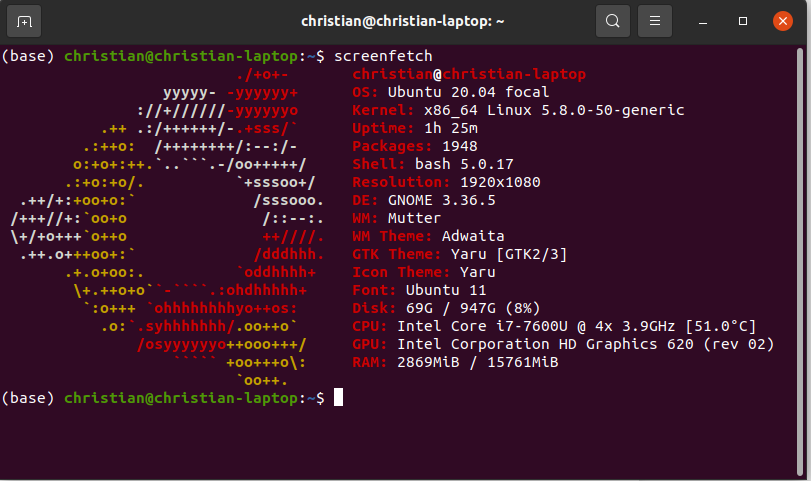